In [1]:
#Database Connection
from pymongo import MongoClient
import json
client = MongoClient("152.46.20.163", 27017)

db = client.yelp_db

#Data Crunching
business_nightlife_p = []
for b in db.business_p.find():
    if b['categories'] is not None:
        if 'Nightlife' in b['categories']:
            business_nightlife_p.append(b['business_id'])

all_checkin_nightlife_p = {}
for ch in db.checkin_p.find():
    if ch['business_id'] in business_nightlife_p:
        for t in ch['time']:
            day_time,count = t.split(':')
            count = int(count)
            if day_time not in all_checkin_nightlife_p.keys():
                all_checkin_nightlife_p[day_time]=0
            all_checkin_nightlife_p[day_time]+=count

days = {'Fri': 5, 'Mon': 1, 'Sat': 6, 'Sun': 0, 'Thu': 4, 'Tue': 2, 'Wed': 3}

all_checkin_p_list = [{j[0]:j[1]} for j in sorted(all_checkin_nightlife_p.items(),key=lambda x:(days[x[0][:3]],int(x[0].split('-')[1])))]
all_checkin_p_values_ts = [item.values()[0] for item in all_checkin_p_list]

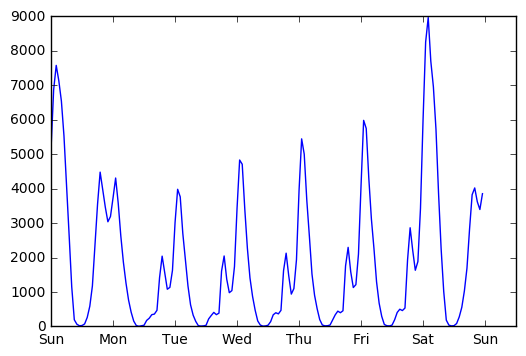

In [2]:
import matplotlib.pyplot as plt
plt.plot(all_checkin_p_values_ts)
plt.xticks([i for i in range(0,169,24)])
locs, labels = plt.xticks()
plt.xticks(locs,['Sun','Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.show()

The graph above shows the number of checkins per hour starting from Sunday 00:00 AM and ending at Sat 23:00, making a total of 168(i.e. 24*7 observations.). The data is mostly periodic. This shows a good possibility of seasonality in the series. We'll take a step-by-step approach towards analysing the series. 
We first check the series for stationarity.
A time series is expected to be stationary for time series models to work. Also a non-stationary time series has more chances of showing an unexpected behavior in the future. More research has been done on stationary series which makes it the more favored option as well. Fortunately, there are methods to convert a non-stationary time series to a stationary one.
A stationary time series has the following three properties - 

1. Constant mean
2. Constant Variance
3. A time independent autocovariance

The formal method to check stationarity are - 

1. Rolling Statistics plot
2. Dickey-Fuller Test

We'll do both of them below.

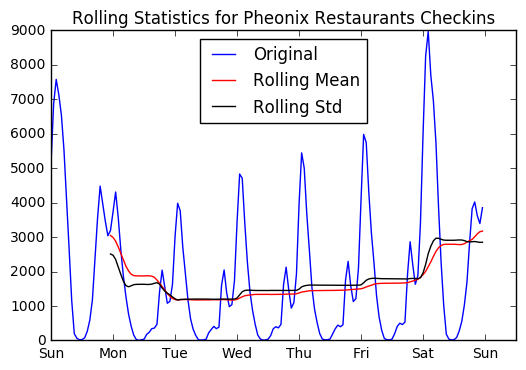

Dickey Fuller Test Results:
Test Statistic                  -5.112506
p-value                          0.000013
#Lags Used                       9.000000
Number of Observations Used    158.000000
Critical Value (5%)             -2.880013
Critical Value (1%)             -3.472431
Critical Value (10%)            -2.576619
dtype: float64


In [3]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
df = all_checkin_p_values_ts
#Rolling Statistics
rolling_avg = pd.DataFrame(df).rolling(window=24,center=False).mean()
rolling_st = pd.DataFrame(df).rolling(window=24,center=False).std()
plt.plot(df,color='blue',label='Original')
plt.plot(rolling_avg,color='red',label='Rolling Mean')
plt.plot(rolling_st,color='black',label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Statistics for Pheonix Restaurants Checkins')
plt.xticks([i for i in range(0,169,24)])
locs, labels = plt.xticks()
plt.xticks(locs,['Sun','Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.show(block=False)

#Dickey Fuller Test
print('Dickey Fuller Test Results:')
dftest = adfuller(df,autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print dfoutput

The rolling mean and std are mostly constant but they increase for Saturday and Sunday with a maximum on Sunday 00:00 am(i.e. weekend night). This shows a lot of checkins during the weekend midnight. As such no trend or seasonality can be noticed from the visual plot, but nevertheless the trend discovery would be made in the following section. Also, the test statistic is way less than critical values meaning the series is stationary.

Decomposition -

By doing decomposition, trend and seasonality of a series are modeled separately and the residuals are shown. It gives us a clear picture of seasonality.

C:\Users\bharat\Anaconda2\lib\site-packages\statsmodels\tsa\filters\filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]


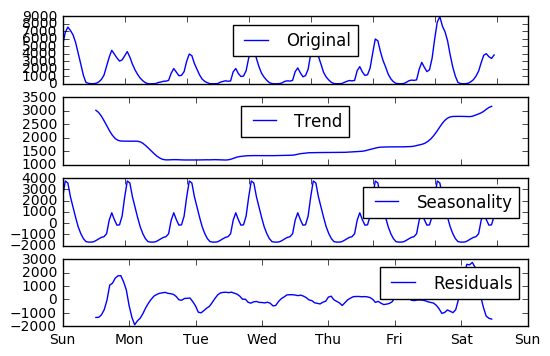

In [4]:
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(np.array(df),freq=24)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(df, label='Original')
plt.legend(loc='best')
plt.xticks([i for i in range(0,169,24)])
locs, labels = plt.xticks()
plt.xticks(locs,['','','','','','','',''])
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.xticks(locs,['','','','','','','',''])
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.xticks(locs,['','','','','','','',''])
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.xticks(locs,['Sun','Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.show()

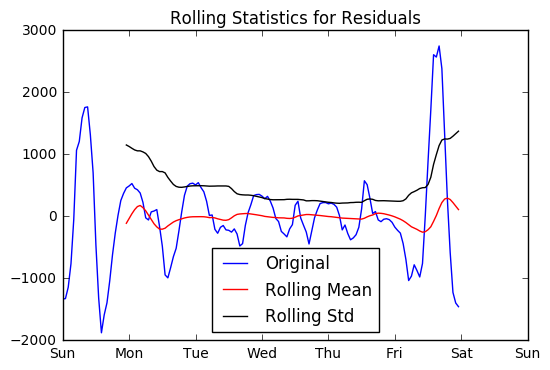

Dickey Fuller Test Results:
Test Statistic                -7.891032e+00
p-value                        4.436048e-12
#Lags Used                     1.000000e+00
Number of Observations Used    1.420000e+02
Critical Value (5%)           -2.882118e+00
Critical Value (1%)           -3.477262e+00
Critical Value (10%)          -2.577743e+00
dtype: float64


In [5]:
df = residual[~np.isnan(residual)]
#Rolling Statistics
rolling_avg = pd.DataFrame(df).rolling(window=24,center=False).mean()
rolling_st = pd.DataFrame(df).rolling(window=24,center=False).std()
plt.plot(df,color='blue',label='Original')
plt.plot(rolling_avg,color='red',label='Rolling Mean')
plt.plot(rolling_st,color='black',label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Statistics for Residuals')
plt.xticks([i for i in range(0,169,24)])
locs, labels = plt.xticks()
plt.xticks(locs,['Sun','Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.show(block=False)

#Dickey Fuller Test
print('Dickey Fuller Test Results:')
dftest = adfuller(df,autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print dfoutput

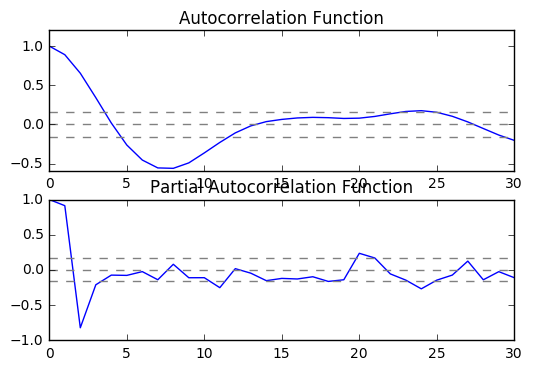

In [6]:
#Forecasting
from statsmodels.tsa.stattools import acf,pacf
lag_acf = acf(df,nlags=30)
lag_pacf = pacf(df,nlags=30,method='ols')

#Plot ACF and PACF
plt.subplot(211)
plt.plot(lag_acf)
plt.title('Autocorrelation Function')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(df)),linestyle='--',color='gray')

plt.subplot(212)
plt.plot(lag_pacf)
plt.title('Partial Autocorrelation Function')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(df)),linestyle='--',color='gray')
plt.show()

Looking at above graph, the p and q value for ARIMA are looking as 4 and 2. But we will manually test the model with minimum error.

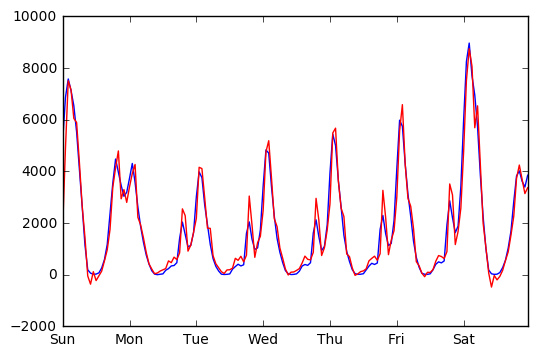

In [7]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
#AR Model
df = pd.DataFrame(all_checkin_p_values_ts,dtype=float)
df.index = pd.to_datetime(df.index,unit='h')
model = sm.tsa.ARMA(df, order=(4, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(df)
plt.plot(results_AR.fittedvalues, color='red')
#plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-df[0])**2))
locs, labels = plt.xticks()
plt.xticks(locs,['Sun','Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.show()

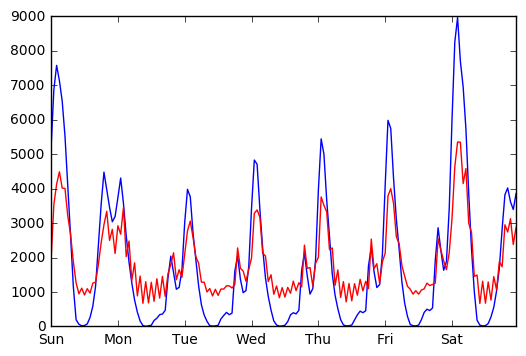

In [8]:
#MA Model
model = sm.tsa.ARMA(df, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.plot(df)
plt.plot(results_MA.fittedvalues, color='red')

locs, labels = plt.xticks()
plt.xticks(locs,['Sun','Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.show()

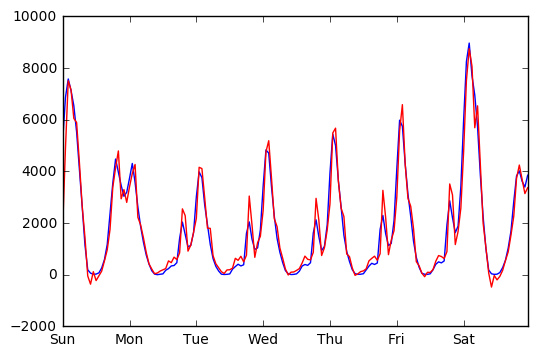

In [9]:
#Combined Model
model = sm.tsa.ARMA(df, order=(4, 1, 2))  
results_ARMA = model.fit(disp=-1)  
plt.plot(df)
plt.plot(results_ARMA.fittedvalues, color='red')
locs, labels = plt.xticks()
plt.xticks(locs,['Sun','Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.show()

C:\Users\bharat\Anaconda2\lib\site-packages\statsmodels\base\data.py:503: FutureWarning: TimeSeries is deprecated. Please use Series
  return TimeSeries(result, index=self.predict_dates)


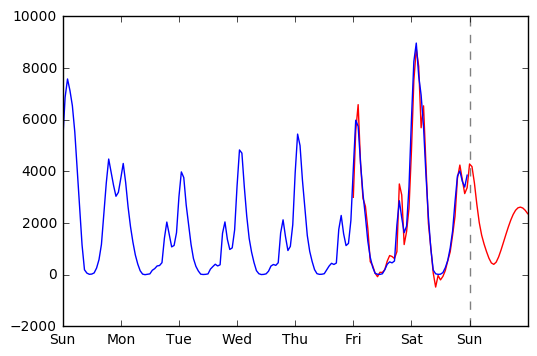

In [10]:
plt.plot(results_ARMA.predict(start='1970-01-06 00:00:00',end='1970-01-09 00:00:00'),color='red')
plt.plot(df,color='blue')
plt.axvline(x='1970-01-08 00:00:00',linestyle='--',color='gray')
locs, labels = plt.xticks()
plt.xticks(locs,['Sun','Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.show()